# Floods Damage Detection on Satellite Images with Machine Learning

## Feature Engineering and Simple Modeling

*Author*: Margarita Popova

*Contact*: margeorita@gmail.com 

*Date*: 12/10/2022

*Notebook:* 1 of 2

## Table Of Contents

 [Introduction](#Introduction)

1. [Preprocessing ](#Preprocessing )
2. [Creating the Tabular Dataset](#Creating-the-Tabular-Dataset)
 - [Preparing the Subset of Data Points with Damage](#Preparing-the-Subset-of-Data-Points-with-Damage)
 - [Preparing the Subset of Data Points without Damage](#Preparing-the-Subset-of-Data-Points-without-Damage)
3. [Exploring the Data](#Exploring-the-Data)
 - [Vectorizing Categorical Data](#Vectorizing-Categorical-Data)
4. [Estimating the Potential Predictors for Logistic Regression](#Estimating-the-Potential-Predictors-for-Logistic-Regression)
5. [Logistic Regression](#Logistic-Regression)
6. [Hyperparameter Optimization](#Hyperparameter-Optimization)
7. [Confusion Matrix](#Confusion-Matrix)

[Preliminary conclusions](#Preliminary-conclusions)

### Introduction

The following work includes analysis of a satellite imagery dataset with damage from Hurricane Harvey. Hurricane Harvey was a devastating Category 4 hurricane that made landfall on Texas and Louisiana in August 2017, causing catastrophic flooding and more than 100 deaths and about 204,000 damaged buildings.

The main aim of the work is to detect damages after hurricanes and floods with machine learning techniques. The following part of the analysis is the attempt to predict damages in data points with a simple Logistic regression model.

### Preprocessing 

For data analysis, we will use such Python libraries as Pandas, Numpy, Scikit-Learn and other.

In [2]:
#import nessesary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

The dataset contains images of flood damage after Hurricane Harvey in Texas, in 2017. The weight of the dataset is 54,4 MB. The source of the dataset can be found at the link https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized, owners of the dataset based on the University of Washington. 

The dataset contains two sub-directories, one per class:

```
dataset/
 - damage/ *.jpeg
 - no_damage/ *.jpeg
```

There is not much data in the data set to build and fit any simple model. However, we can create a CSV database based on the image names, since each image's filenames have the coordinates of the center points, and we can add some additional features based on the geographic location of each data point.

First of all, we should extract filenames from the dataset. The easiest way to do that is using Bash.

Note: If you don't have the ability to run the Bash code yourself, you can use the output that comes with two csv files.

```
Bash code:
1. cd <add your path to dataset>/dataset/damage
2. ls > damage.csv | mv -i damage.csv ../../dataset/
3. cd ../no_damage/
4. ls > no_damage.csv | mv -i no_damage.csv ../../dataset/
```


The code explanations:
1. Change the directory to the folder where the dataset is located now. Choose the subfolder `damage` first. 
 - For example: `cd Downloads/Margarita_Popova_Floods_Capstone/dataset/damage`
2. List the items in the directory and save them as CSV-file. Then move it to the main folder `dataset`
3. Change the directory to the folder `no_damage`
4. List the items in the directory and save them as CSV-file. Then move it to the main folder `dataset`

Now we have two CSV with full names of images including the extensions. The CSV-files are attached.

### Creating the Tabular Dataset

#### Preparing the Subset of Data Points with Damage

Whith Pandas we can split a single column with filenames to get latitude and longitude and mark images with damages and without damages. Let's load the first csv - `damage.csv`.

In [2]:
#load damage.csv
colname = ['img_name'] #name the column
damage_raw = pd.read_csv('dataset/damage.csv',names=colname, header=None)
damage_raw

img_name
0               -93.528502_30.987438.jpeg
1                 -93.5302_30.988157.jpeg
2       -93.53950999999999_30.982944.jpeg
3               -93.539521_30.982434.jpeg
4               -93.540151_30.982689.jpeg
...                                   ...
14016            -97.001367_28.47523.jpeg
14017           -97.001414_28.622662.jpeg
14018           -97.001414_28.868231.jpeg
14019   -97.00144_28.622428999999997.jpeg
14020  -97.001677_28.864984000000003.jpeg

[14021 rows x 1 columns]

In our case, the first place in the file names is the longitude, the second is the latitude, separated from the longitude by the `_` - underscore. Split these coordinates using a delimiter.

In [6]:
#split latitude and longitude with delimiter '_'
damage_raw[['lon','lat']] = damage_raw['img_name'].str.split('_', expand=True)

In [7]:
#sanity check
damage_raw

img_name                 lon  \
0               -93.528502_30.987438.jpeg          -93.528502   
1                 -93.5302_30.988157.jpeg            -93.5302   
2       -93.53950999999999_30.982944.jpeg  -93.53950999999999   
3               -93.539521_30.982434.jpeg          -93.539521   
4               -93.540151_30.982689.jpeg          -93.540151   
...                                   ...                 ...   
14016            -97.001367_28.47523.jpeg          -97.001367   
14017           -97.001414_28.622662.jpeg          -97.001414   
14018           -97.001414_28.868231.jpeg          -97.001414   
14019   -97.00144_28.622428999999997.jpeg           -97.00144   
14020  -97.001677_28.864984000000003.jpeg          -97.001677   

                           lat  
0               30.987438.jpeg  
1               30.988157.jpeg  
2               30.982944.jpeg  
3               30.982434.jpeg  
4               30.982689.jpeg  
...                        ...  
14016            28.47523.jpeg  
14017           28.622662.jpeg  
14018           28.868231.jpeg  
14019  28.622428999999997.jpeg  
14020  28.864984000000003.jpeg  

[14021 rows x 3 columns]

We do not need the extension `.jpeg` in the latitude column, so let's remove it.

In [8]:
#delete the extension from lat column
damage_raw['lat']  = damage_raw['lat'].str[:-5] #take all characters except last 5 (.jpeg)

The most important part is to add a column which marks the damages as 1. Afterwards, we will concatenate this data frame with the data frame without damage and we want to have the opportunity to group and process data points with damage and without.

In [9]:
#add column damage with value 1
damage_raw = damage_raw.assign(damage=1)
damage_raw

img_name                 lon  \
0               -93.528502_30.987438.jpeg          -93.528502   
1                 -93.5302_30.988157.jpeg            -93.5302   
2       -93.53950999999999_30.982944.jpeg  -93.53950999999999   
3               -93.539521_30.982434.jpeg          -93.539521   
4               -93.540151_30.982689.jpeg          -93.540151   
...                                   ...                 ...   
14016            -97.001367_28.47523.jpeg          -97.001367   
14017           -97.001414_28.622662.jpeg          -97.001414   
14018           -97.001414_28.868231.jpeg          -97.001414   
14019   -97.00144_28.622428999999997.jpeg           -97.00144   
14020  -97.001677_28.864984000000003.jpeg          -97.001677   

                      lat  damage  
0               30.987438       1  
1               30.988157       1  
2               30.982944       1  
3               30.982434       1  
4               30.982689       1  
...                   ...     ...  
14016            28.47523       1  
14017           28.622662       1  
14018           28.868231       1  
14019  28.622428999999997       1  
14020  28.864984000000003       1  

[14021 rows x 4 columns]

#### Preparing the Subset of Data Points without Damage

The same sequence we should repeat for the  `no_damage.csv`.

In [10]:
#load no_damage.csv
colname = ['img_name']
no_damage_raw = pd.read_csv('dataset/no_damage.csv',names=colname, header=None)
no_damage_raw

img_name
0              -95.061275_29.831535.jpeg
1     -95.061412_29.826522999999998.jpeg
2     -95.061825_29.828608000000003.jpeg
3              -95.061894_30.007746.jpeg
4     -95.061908_29.828245000000003.jpeg
...                                  ...
7031  -97.001436_28.876759999999997.jpeg
7032   -97.00144_28.622428999999997.jpeg
7033  -97.001677_28.864984000000003.jpeg
7034  -97.001948_28.633053999999998.jpeg
7035  -97.001979_28.623572999999997.jpeg

[7036 rows x 1 columns]

In [11]:
#split y and x with delimeter '_'
no_damage_raw[['lon','lat']] = no_damage_raw['img_name'].str.split('_', expand=True)

In [12]:
#delete the extension
no_damage_raw['lat']  = no_damage_raw['lat'].str[:-5]


Add a column which marks the damages as 0 since there are no damages in the data point in the current subset.

In [13]:
#add column damage with value 0
no_damage_raw = no_damage_raw.assign(damage=0)
no_damage_raw

img_name         lon                 lat  \
0              -95.061275_29.831535.jpeg  -95.061275           29.831535   
1     -95.061412_29.826522999999998.jpeg  -95.061412  29.826522999999998   
2     -95.061825_29.828608000000003.jpeg  -95.061825  29.828608000000003   
3              -95.061894_30.007746.jpeg  -95.061894           30.007746   
4     -95.061908_29.828245000000003.jpeg  -95.061908  29.828245000000003   
...                                  ...         ...                 ...   
7031  -97.001436_28.876759999999997.jpeg  -97.001436  28.876759999999997   
7032   -97.00144_28.622428999999997.jpeg   -97.00144  28.622428999999997   
7033  -97.001677_28.864984000000003.jpeg  -97.001677  28.864984000000003   
7034  -97.001948_28.633053999999998.jpeg  -97.001948  28.633053999999998   
7035  -97.001979_28.623572999999997.jpeg  -97.001979  28.623572999999997   

      damage  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
7031       0  
7032       0  
7033       0  
7034       0  
7035       0  

[7036 rows x 4 columns]

Finally, we can concatenate our two subsets in a single tabular dataset and check the final shape of the dataset.

In [15]:
#concatinate damage and no_damage dataframes
merged = pd.concat([damage_raw, no_damage_raw], ignore_index=True)

In [18]:
#sanity check
merged.sample(7)

img_name                 lon  \
16041    -95.2841_29.610508000000003.jpeg            -95.2841   
16372    -95.37844100000001_30.04068.jpeg  -95.37844100000001   
10505  -95.635554_29.841896999999996.jpeg          -95.635554   
13258  -96.929107_28.724621000000003.jpeg          -96.929107   
15403  -95.222773_30.030171999999997.jpeg          -95.222773   
13628  -96.973774_28.777115999999996.jpeg          -96.973774   
11804  -95.649013_29.834384000000004.jpeg          -95.649013   

                      lat  damage  
16041  29.610508000000003       0  
16372            30.04068       0  
10505  29.841896999999996       1  
13258  28.724621000000003       1  
15403  30.030171999999997       0  
13628  28.777115999999996       1  
11804  29.834384000000004       1

In [19]:
#check shapeof the dataset
print(f'The dataset includes {merged.shape[0]} rows and {merged.shape[1]} columns')

The dataset includes 21057 rows and 4 columns


Since we created the dataset by ourselves using only filenames there are no missing values. 

But the dataset may contain duplicated images, let's check it.

In [20]:
#check duplicates
merged.duplicated().sum()

0

There are no duplicates in the dataset.

Let's check the ratio of damage values in the dataset.

In [40]:
#damage vs. no_damage
print(f'There is {len(merged[merged["damage"]==1])} images with damages in the dataset')
print(f'There is {len(merged[merged["damage"]==0])} images without damages in the dataset')

There is 14021 images with damages in the dataset
There is 7036 images without damages in the dataset


In [42]:
#classes ratio
merged['damage'].value_counts(normalize=True)

1    0.665859
0    0.334141
Name: damage, dtype: float64

As we see there is an imbalance in the dataset which may be the cause of issues with modelling and predictions. If we just predict that all data points contain damage (the value in the column `damage` is equal to 1) we will have the accuracy of that silly prediction at 66% which is not bad in some cases. So, the accuracy of the future model should be higher than 66% to assure us that it studied some patterns in the data.

To have an opportunity to use the coordinates in the spatial analysis software we should save the dataset as CSV file.

In [12]:
#save concatinated data as csv
merged.to_csv('merged_data.csv')

### Exploring the Data

In term of better understanding data patterns, we can use open source data to add some terrain metrics to the dataset.
USGS share spatial data which you can download from portal https://apps.nationalmap.gov/downloader/. We can gain some useful information from terrain parameters, so, let's download and process Digital Elevation Model (DEM).

For extracting data from DEM I used ArcGIS - software for processing spatial data. DEM contains data about height at every point of the model and you can also build other spatial products such as map of aspects, slopes and other based on DEM. 

I turned data points from `merged_data.csv` into a shape-file with geometry type 'Point' using columns with coordinates. Then I extracted data from DEM and maps based on DEM using standard ArcGIS tools (Extract Values to Points ). In addition, I estimated and added distance to the closest water bodies.

The DEM and data points from our dataset are shown below as an overview map created with ArcGIS.

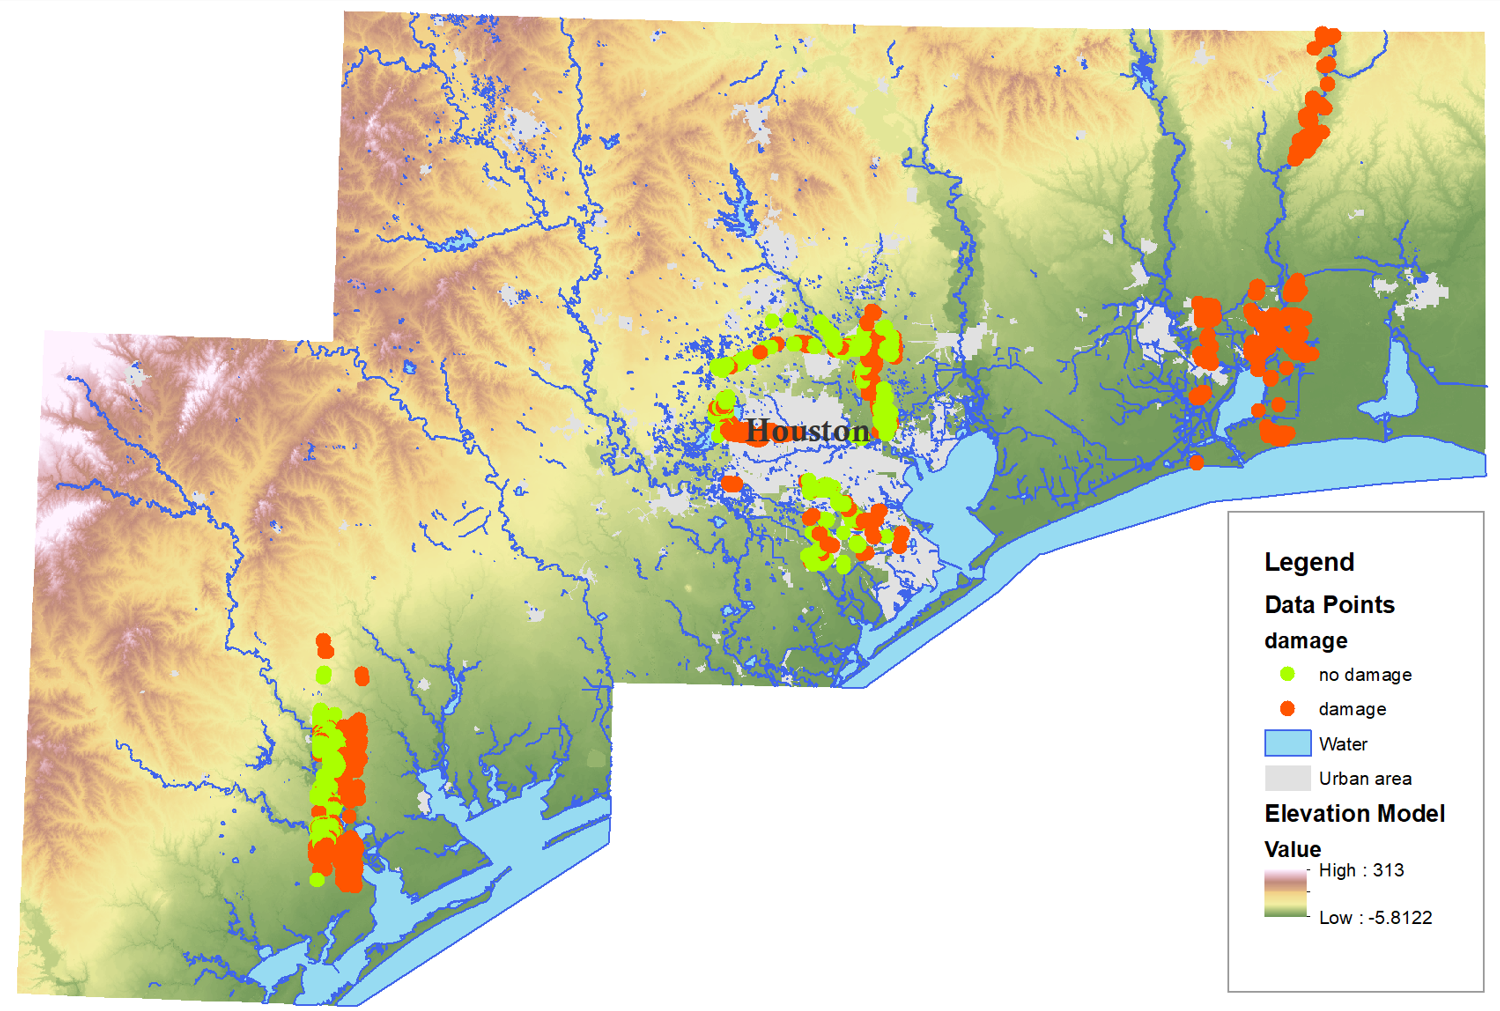

As we see on the map the data points are located close to the seacoast in the south of Texas, USA.

The dataset with extra data was saved in `extra_data.csv`. Let's explore new terrain metrics.

In [4]:
#load data with extra features
analysis_data = pd.read_csv("extra_data.csv", index_col=0)
analysis_data.head()

lon        lat  damage  elevation  \
img_name                                                                     
-93.528502_30.987438.jpeg         -93.528502  30.987438       1  30.110001   
-93.5302_30.988157.jpeg           -93.530200  30.988157       1  29.809999   
-93.53950999999999_30.982944.jpeg -93.539510  30.982944       1  29.080000   
-93.539521_30.982434.jpeg         -93.539521  30.982434       1  28.990000   
-93.540151_30.982689.jpeg         -93.540151  30.982689       1  29.080000   

                                     near_dist  slope aspect  
img_name                                                      
-93.528502_30.987438.jpeg          2505.718018  1.188     NW  
-93.5302_30.988157.jpeg            2369.253418  0.422     NW  
-93.53950999999999_30.982944.jpeg  1957.698608  0.179   flat  
-93.539521_30.982434.jpeg          1908.071533  0.157      E  
-93.540151_30.982689.jpeg          1903.523438  0.139   flat

In [4]:
#check the dataset shape
print(f'Now our dataset contains {analysis_data.shape[0]} rows and {analysis_data.shape[1]} columns')

Now our dataset contains 21057 rows and 7 columns


New features explanation:
 - `elevation` - a surface height in meters
 - `near_dist` - distance to the closest water body in meters
 - `slope` - slope degree
 - `aspect` - the compass direction that a terrain surface faces

Let's check the distribution of the terrain metrics.

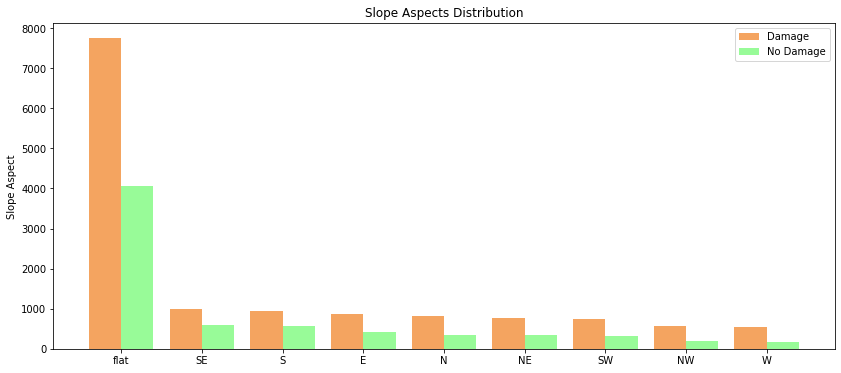

In [59]:
#count data points with damage for each aspect
damage_count = analysis_data['aspect'].loc[analysis_data['damage']==1].value_counts()
#count data points without damage for each aspect
no_damage_count =   analysis_data['aspect'].loc[analysis_data['damage']==0].value_counts()

units = np.arange(9)  # we have 9 aspects
width = 0.4 #bar width

#plot distribution by aspects
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
rects1 = ax.bar(units, damage_count, width, color='#F4A460')
rects2 = ax.bar(units+width, no_damage_count, width, color='#98FB98')

#labels
ax.set_ylabel('Count')
ax.set_ylabel('Slope Aspect')
ax.set_title('Slope Aspects Distribution')
ax.set_xticks(units + width / 2) #make sure the label will be between bars
ax.set_xticklabels( ('flat', 'SE', 'S', 'E', 'N', 'NE', 'SW', 'NW', 'W') )

ax.legend( (rects1[0], rects2[0]), ('Damage', 'No Damage') )

plt.show()

The majority of points are located on the flat surfaces. Between others slopes we see that the are slighly more points on the South-Eastern and Sousthern slopes. These patterns are quite typical for seacosts where we do not have a big amplitudes in heights and slopes often absolutly flat.

In [5]:
#select elevation values for points with damage
damage_count = analysis_data.query('damage == 1')['elevation']
#select elevation values for points without damage
no_damage_count = analysis_data.query('damage == 0')['elevation']

#build histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=damage_count,
    name='Damage', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=0,
        end=50,
        size=2
    ),
    marker_color='#F4A460'
))
fig.add_trace(go.Histogram(
    x=no_damage_count,
    name='No Damage',
    xbins=dict(
        start=0,
        end=50,
        size=2
    ),
    marker_color='#98FB98'
))

fig.update_layout(
    title_text='Elevation Distribution', # title of plot
    xaxis_title_text='Elevation, m', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

Height distribution is non-uniform. The majority of points located on the elevation above 12 meters which is may be related to the specificity of real estate construction: often, it is not permitted to construct in the floodplain and too close to the coast. The floodplains and seashores (or lakeshores) are always the lowest parts of the relief with the lowest elevation values.

Also, there is a local maximum of damages on elevations between 20 and 25 meters which may be also related to the specificity of the real estate construction in Texas.

In [6]:
#select slope values for points with damage and without damage
damage_count = analysis_data.query('damage == 1')['slope']
no_damage_count = analysis_data.query('damage == 0')['slope']

#build histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=damage_count,
    name='Damage', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=0,
        end=12,
        size=0.5
    ),
    marker_color='#F4A460'
))
fig.add_trace(go.Histogram(
    x=no_damage_count,
    name='No Damage',
    xbins=dict(
        start=0,
        end=12,
        size=0.5
    ),
    marker_color='#98FB98'
))

fig.update_layout(
    title_text='Slope Degree Distribution', # title of plot
    xaxis_title_text='Slope', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

As was mentioned above, the seacoasts do not have a high amplitude of height and also there is no high variability in slope degrees too. On the seashores, terrain irregularities are covered by sediments (sand, gravel, loam) that rivers and irregular streams inflict from higher areas to lower ones (thanks to gravity) making shore valleys quite flat. 

In fact, we see that the majority of the points in our dataset are located on slopes no more than 3 degrees as well the majority of damages.

#### Vectorizing Categorical Data

To have a chance to use aspects as predictors in the Logistic Regression we should vectorize them. Let's create dummy variables from the aspect column.

In [5]:
#create dummy aspects
dummy_aspect = pd.get_dummies(analysis_data[['aspect']])
dummy_aspect.head(3)

aspect_E  aspect_N  aspect_NE  aspect_NW  \
img_name                                                                      
-93.528502_30.987438.jpeg                 0         0          0          1   
-93.5302_30.988157.jpeg                   0         0          0          1   
-93.53950999999999_30.982944.jpeg         0         0          0          0   

                                   aspect_S  aspect_SE  aspect_SW  aspect_W  \
img_name                                                                      
-93.528502_30.987438.jpeg                 0          0          0         0   
-93.5302_30.988157.jpeg                   0          0          0         0   
-93.53950999999999_30.982944.jpeg         0          0          0         0   

                                   aspect_flat  
img_name                                        
-93.528502_30.987438.jpeg                    0  
-93.5302_30.988157.jpeg                      0  
-93.53950999999999_30.982944.jpeg            1

After vectorization, we should concatenate dataframes and drop the old column `aspect`.

In [6]:
#concatinate dummy dataframe with the original one
numeric_df = pd.concat((analysis_data, dummy_aspect), axis = 1)
numeric_df.head(3)

lon        lat  damage  elevation  \
img_name                                                                     
-93.528502_30.987438.jpeg         -93.528502  30.987438       1  30.110001   
-93.5302_30.988157.jpeg           -93.530200  30.988157       1  29.809999   
-93.53950999999999_30.982944.jpeg -93.539510  30.982944       1  29.080000   

                                     near_dist  slope aspect  aspect_E  \
img_name                                                                 
-93.528502_30.987438.jpeg          2505.718018  1.188     NW         0   
-93.5302_30.988157.jpeg            2369.253418  0.422     NW         0   
-93.53950999999999_30.982944.jpeg  1957.698608  0.179   flat         0   

                                   aspect_N  aspect_NE  aspect_NW  aspect_S  \
img_name                                                                      
-93.528502_30.987438.jpeg                 0          0          1         0   
-93.5302_30.988157.jpeg                   0          0          1         0   
-93.53950999999999_30.982944.jpeg         0          0          0         0   

                                   aspect_SE  aspect_SW  aspect_W  aspect_flat  
img_name                                                                        
-93.528502_30.987438.jpeg                  0          0         0            0  
-93.5302_30.988157.jpeg                    0          0         0            0  
-93.53950999999999_30.982944.jpeg          0          0         0            1

In [7]:
numeric_df = numeric_df.drop(columns = 'aspect')

In [8]:
#check the new shape of the dataset
print(f'Now our dataset contains {numeric_df.shape[1]} columns and {numeric_df.shape[0]} rows.')

Now our dataset contains 15 columns and 21057 rows.


### Estimating the Potential Predictors for Logistic Regression

The target of the predictions in the current analysis is column `damage` because we want to estimate whether is it possible to predict the damages after floods using only numeric data describing the feature of relief.

Before the modelling process, we should explore correlations between dependent  and independent variables. Exploring the correlations can allow us to see which features are likely to be the most impactful on our dependent variable.

First, let's define the dependent variable as y and the independent variables as X.

In [9]:
#create varibles to estimate correlation
y = numeric_df['damage'] #dependent value
X = numeric_df.drop(columns=['damage']) #independent values. we use only numeric columns to estimate correlation

Visualization of correlation will help us to estimate the best predictors. Best predictors will have higher values and will be coloured more intensively in a heatmap.

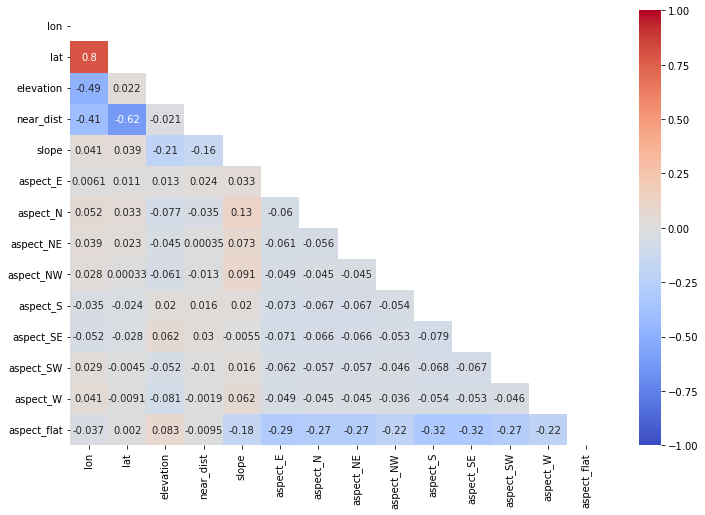

In [10]:
#plot heatmap
plt.figure(figsize=(12,8))

# creating mask of duplicated combinations
mask = np.triu(np.ones_like(X.corr(), dtype=bool))
sns.heatmap(X.corr(), mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True)

plt.show()

The best predictors according to the heatmap are `lat`, `elevation`, `near_dist`, and all southern slopes.

We can estimate p-values for every column using the function to estimate whether the correlation is significant or insignificant. A p-value less than 0.05 is significant and we will use it as a significance threshold.

In [11]:
def pearson_df(dataframe, target, alpha=0.05):
    '''
    This function takes a dataframe with a column of interest (target), 
    a significance threshold (alpha) as inputs. It then calculates the correlation coefficients
    and p-values using scipy.stats.pearsonr(), and returns a dataframe of the results
    
    Parameters:
    -----------
    dataframe: a pandas dataframe containing the data to compare
    target: a string specifying one of the columns in the dataframe to compare to the rest of the data
    alpha: a significance threshold for evaluating p-values (default 0.05)
    
    Returns:
    --------
    output: a dataframe containing correlation coefficients and p-values for each variable in dataframe w.r.t. the target variable
    
    '''
    
    # Instantiating empty lists
    variable_names = []
    corr_list = []
    p_value_list = []
    
    # Looping across all of the columns in the dataframe
    for column in range(dataframe.shape[1]):
        
        # Calculating the coefficient and p-value for each column w.r.t. the target variable
        corr, p_value = pearsonr(dataframe.iloc[:, column], dataframe[target])
        
        # Add the column name, coefficient, and p-value to their respective lists
        variable_names.append(dataframe.columns[column])
        corr_list.append(corr)
        p_value_list.append(p_value)

    # Turn the three lists into a dataframe for easier viewing
    output = pd.DataFrame(index=variable_names, data={'coefficient': corr_list, 'p-value': p_value_list})
    
    # Add a column which states whether the correlation is significant
    output[f'p-value <= {alpha}'] = np.where(output['p-value'] <= alpha, True, False)
    
    # Drop the target variable from the dataframe
    output = output.drop(target)
    
    print(f'Correlations between data columns and {target}:')
    
    return output

Correlations between data columns and `damage`:

In [12]:
#create dataframe with p-values
correlation_df = pearson_df(numeric_df, 'damage')
correlation_df

Correlations between data columns and damage:


coefficient        p-value  p-value <= 0.05
lon             0.123302   4.013649e-72             True
lat             0.005249   4.463132e-01            False
elevation      -0.185358  4.219108e-162             True
near_dist       0.036043   1.680805e-07             True
slope           0.068360   3.057490e-23             True
aspect_E        0.005741   4.048037e-01            False
aspect_N        0.007162   2.986958e-01            False
aspect_NE       0.012684   6.569565e-02            False
aspect_NW       0.027700   5.817744e-05             True
aspect_S       -0.022176   1.290320e-03             True
aspect_SE      -0.029108   2.394765e-05             True
aspect_SW       0.024566   3.637424e-04             True
aspect_W        0.048108   2.856465e-12             True
aspect_flat    -0.024237   4.359216e-04             True

We can see that the correlation is not significant between `latitude`, `aspect_E`, `aspect_N`, and `aspect_NE`, the rest of the columns may be used for predictions.

Finally, we can visualize the strength of these correlations:

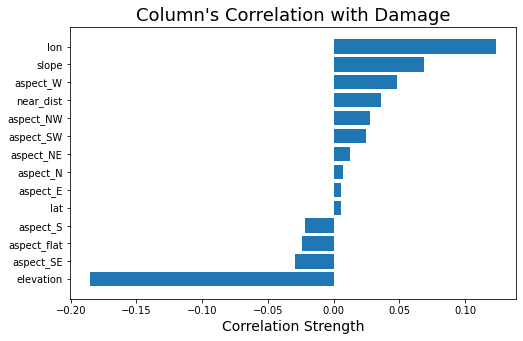

In [13]:
#plot correlation
plt.figure(figsize=(8,5))
correlation_df.sort_values(by='coefficient', inplace=True)
plt.barh(correlation_df.index, correlation_df["coefficient"])
plt.title("Column's Correlation with Damage", fontsize=18)
plt.xlabel("Correlation Strength", fontsize=14)
plt.show()

Some features have a negative correlation with damage, for example - elevation. The negative correlation means the less the elevation the more damages.

A positive correlation with longitude means more damage eastward because latitude values increase from west to east. Also, more damage on steeper slopes with higher grade values.

### Logistic Regression

After the estimation of the correlation and p-values, we can perform the Logistic Regression model.

Let's define X and y again.

In [17]:
#defign X and y
X = numeric_df[['slope', 'elevation', 'aspect_W','lon', 'aspect_S','aspect_SE']] # independent variables or features
y = numeric_df['damage'] # dependent variable or target

We always should add constants to independent variables.

In [18]:
#add constant
X_const = sm.add_constant(X)

Using X with constant we are creating the Logistic regression model.

In [19]:
#build a model
logreg= sm.Logit(y,X_const)

#fit model
logreg_results = logreg.fit()

#get results
logreg_results.summary()

Optimization terminated successfully.
         Current function value: 0.616922
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 damage   No. Observations:                21057
Model:                          Logit   Df Residuals:                    21050
Method:                           MLE   Df Model:                            6
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.03163
Time:                        10:08:16   Log-Likelihood:                -12991.
converged:                       True   LL-Null:                       -13415.
Covariance Type:            nonrobust   LLR p-value:                4.803e-180
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2039      2.382      7.221      0.000      12.534      21.873
slope          0.0810      0.018      4.611      0.000       0.047       0.115
elevation     -0.0318      0.002    -19.190      0.000      -0.035      -0.029
aspect_W       0.4218      0.093      4.553      0.000       0.240       0.603
lon            0.1662      0.025      6.626      0.000       0.117       0.215
aspect_S      -0.1461      0.056     -2.615      0.009      -0.256      -0.037
aspect_SE     -0.1343      0.056     -2.386      0.017      -0.245      -0.024
==============================================================================
"""

Hurricane Harvey came from the South and through the area of Texas, it was moving from West to East. According to the logistic regression summary, the number of damages is increasing on the West slopes with a factor of 0.42 - that is the highest coefficient in the summary. The western slopes may be more affected as they are on the windward side in our case.

In [20]:
# Calculate the accuracy
numeric_df['y_pred'] = logreg_results.predict(X_const)
np.mean((numeric_df['y_pred'] >= 0.5) == numeric_df['damage'])

0.6657643538965664

The accuracy is slightly more than 66% which is unsatisfying because we can get the same result just predict that all datapoint contain damage.

We can try to enhance the model with Hyperparameter Optimization.

### Hyperparameter Optimization

We will use the same dependent and independent variables but with different parameters C. A high value of C tells the model to give more weight to the training data. A lower value of C will indicate the model gives complexity more weight at the cost of fitting the data.

To make our computations easier and quikier lets's build a pipeline.

First, split data on training and test subsets with a ratio 0.3, which is mean we will use 70% of the whole dataset as a training subset and 30% as a test subset.

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

First, let's set up our pipeline which includes a StandardScaler and then fits a logistic regression classifier.

In [56]:
#define estimators and build a pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

basic_pipe = Pipeline(estimators)

In [57]:
#fit the pipeline
basic_pipe.fit(X_train, y_train)
#estimate accuracy
basic_pipe.score(X_test, y_test)

0.6666666666666666

We still have accuracy slightly greater than 66% (66.6%) but if we run logistic regression several times and take the average accuracy we can get an even less score. 

Let's try 5-fold cross-validation to evaluate the performance of the pipeline.

In [58]:
#5-fold cross-validation
avg_val_score = np.mean(cross_val_score(basic_pipe, X_train, y_train, cv=5))
avg_val_score

0.6653096841117545

Indeed we got a little bit smaller accuracy - 66.5%.

What we can do is try to find the best C parameter which may help us increase accuracy. We can estimate several C using a loop.

In [44]:
#create list of C
c_list = np.array([.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000])
#create lists for scores
validation_scores = []
train_scores = []

#fit logistic regression with every C
for c in c_list:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(X_train,y_train)
    
    train_scores.append(my_logreg.score(X_train,y_train))
    validation_scores.append(my_logreg.score(X_test,y_test))

C:\Users\marge\PycharmProjects\pythonProject\machine_learning\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<function matplotlib.pyplot.show(close=None, block=None)>

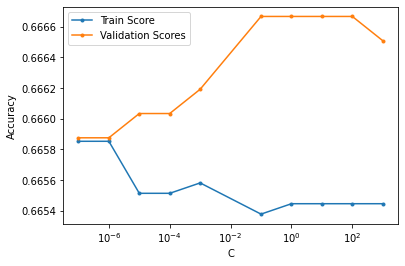

In [45]:
#plot C and their scores
plt.figure()
plt.plot(c_list, train_scores,label="Train Score",marker='.')
plt.plot(c_list, validation_scores,label="Validation Scores",marker='.')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('savefig1.png')
plt.show

According the plot the best C is equal 0.000001, let's estimate the accuracy with that parameter.

In [54]:
#define estimators and build a pipeline
estimators = [('normalise', StandardScaler()),
                  ('model', LogisticRegression(C=0.000001))] #add the best C parameter

pipe = Pipeline(estimators)

In [55]:
#fit the pipeline
pipe.fit(X_train, y_train)
#estimate accuracy
pipe.score(X_test, y_test)

0.665875276986388

Well, we still have a low accuracy which does not satisfy our condition that the accuracy should be greater than 66% since we have 66% data points with damages.

### Confusion Matrix

The confusion Matrix is a performance measurement for machine learning classification. The confusion matrix helps us understand how many positive classes were predicted correctly. In our case, positive class is an presence of damage in the data point.

Let's build confusion matrix with our basic pipeline with default parameter C because we want to give more weight to the training data.

In [38]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [59]:
# get class predictions
y_pred = basic_pipe.predict(X_test)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted No Damage", "Predicted Damage"],
    index=["True No Damage", "True Damage"]
)

display(cf_df)

Predicted No Damage  Predicted Damage
True No Damage                   22              2089
True Damage                      17              4190

C:\Users\marge\PycharmProjects\pythonProject\machine_learning\my_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


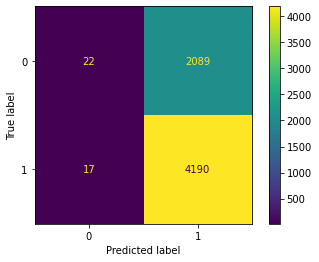

In [60]:
#plot the confusion matrix
plot_confusion_matrix(basic_pipe, X_test, y_test)
plt.savefig('confusion_logreg.png')

The model is good in predictions of True Positive class and can not predict True Negative class.

In our case True Positive is a damage, True Neative is no damage. In our case, True Positive is damage, True Negative is no damage. Unfortunately, the model cannot predict the negative class, as it is an imbalance in the classes as well in the terrain metrics.

In an emergency, it is important to predict as many points of damage as possible, because it can be about rescuing people stuck on rooftops in the middle of floods and storms. Thus, we can justify the model if it has a high recall.

The recall is a metric which describes how many predicted positive classes are predicted correctly. In our case - how many points with predicted damage were indeed damaged.

The second metrics is a Precision which is describes all predicted Positive classes including False Positive.

In [61]:
# Precision 
from sklearn.metrics import precision_score

# precision_score(true labels, predicted labels)
precision_score(y_test, y_pred)

0.6673037107819717

In [62]:
# Recall
from sklearn.metrics import recall_score

# recall_score(true labels, predicted labels)
recall_score(y_test, y_pred)

0.9959591157594485

For our model is more important to find Damage - True Positive and False Negative, so the high Recall - 99.5% is pretty well for our goals. On the other hand the low Precision does not allow us to trust such a model.

## Preliminary conclusions

The simple models such as Logistic regression give us results quickly and have high interoperability, but as we learned Logistic regression could not predict flood damages using only terrain metrics and coordinates. 

Logistic regression or other classic models such as kNN, and Decision Tree may be effective if you are working with seasonal floods which occur annually on some rivers thanks to spring snow melting or rainy seasons. In such cases, you can easily find patterns in the flood regime by knowing the relief metrics and hydrological features of rivers.

Unfortunately, we are working with a non-seasonal flood after Hurricane Harvey and there are not enough numeric data to predict the devastating consequences of that catastrophe. The idea  to predict damages on the images using only coordinates of the central point of the image and extra terrain metrics was really ambitious but it is absolutely ineffective. That is the main reason why we should detect damages by analyzing satellite images using more difficult models for deep learning such as CNN.